<a href="https://colab.research.google.com/github/AgnesElza/subscription-retention-analytics/blob/main/02_exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook continues from 01_data_preparation.ipynb, where we explored and cleaned the KKBox dataset and engineered aggregated features. Here, we focus on exploratory analysis to identify churn patterns.

In [ ]:
# Mounting Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Prepared Data

In [ ]:
import pandas as pd

data_path = "/content/drive/MyDrive/data_science_projects/kkbox_project/data"

train = pd.read_csv(f"{data_path}/train.csv")
members_clean = pd.read_csv(f"{data_path}/members_clean.csv")
tx_agg = pd.read_csv(f"{data_path}/tx_agg.csv")
logs_agg = pd.read_csv(f"{data_path}/user_logs_agg.csv")

## Overlap Check (sanity step before merging)

In [ ]:
# See how many train users exist in each dataset.
print("Train users:", train['msno'].nunique())
print("In members:", train['msno'].isin(members_clean['msno']).mean())
print("In tx_agg:", train['msno'].isin(tx_agg['msno']).mean())
print("In logs_agg:", train['msno'].isin(logs_agg['msno']).mean())

Train users: 992931
In members: 0.8834057955688764
In tx_agg: 1.0
In logs_agg: 0.8761192872415102


The churn label dataset contains ~993k users. About 88% have demographic info in members, 100% have subscription/payment history in transactions, and ~88% have listening activity in logs. This means our final modeling dataset will cover ~870k users with complete information

## Merge to Create Master Dataset

In [ ]:
df = train.merge(members_clean, on="msno", how="left") \
          .merge(tx_agg, on="msno", how="left") \
          .merge(logs_agg, on="msno", how="left")

print(df.shape)
print(df.isnull().mean().sort_values(ascending=False))  # check coverage

(992931, 32)
bd                          0.608205
complete_listens            0.123881
active_days                 0.123881
max_unique_songs_per_day    0.123881
total_secs_mean             0.123881
avg_unique_songs_per_day    0.123881
completion_ratio            0.123881
last_activity_date          0.123881
total_listens               0.123881
total_secs_sum              0.123881
registered_via              0.116594
city                        0.116594
registration_init_time      0.116594
reg_year                    0.116594
reg_month                   0.116594
gender                      0.116594
std_plan_days               0.013502
avg_discount_rate           0.001493
avg_plan_days               0.000000
auto_renew_rate             0.000000
n_txns                      0.000000
cancel_rate                 0.000000
msno                        0.000000
is_churn                    0.000000
zero_paid_rate              0.000000
share_30d                   0.000000
last_gap_days            

After merging all sources, we have ~993k labeled users with 32 features. Around 61% of users have missing or invalid ages (bd), while ~12% of users are missing listening activity features due to no available logs.

## Handling Missing Values

In [ ]:
# Drop bd entirely (since >60% missing, may introduce bias)
df.drop("bd", axis=1, inplace=True)

In [ ]:
# missing logs = no recorded engagement → likely churny behavior
log_features = [
    'complete_listens', 'active_days', 'max_unique_songs_per_day',
    'total_secs_sum', 'total_listens', 'total_secs_mean',
    'avg_unique_songs_per_day', 'completion_ratio'
]
df[log_features] = df[log_features].fillna(0)
df['last_activity_date'] = df['last_activity_date'].fillna(pd.Timestamp("1970-01-01"))

# Demographics (members info)
df['city'] = df['city'].fillna(-1)  # unknown city
df['registered_via'] = df['registered_via'].fillna(-1)
df['gender'] = df['gender'].fillna("unknown")

df['registration_init_time'] = df['registration_init_time'].fillna(pd.Timestamp("1970-01-01"))
df['reg_year'] = df['reg_year'].fillna(0).astype(int)
df['reg_month'] = df['reg_month'].fillna(0).astype(int)

# Transactions features
df['std_plan_days'] = df['std_plan_days'].fillna(0)
df['avg_discount_rate'] = df['avg_discount_rate'].fillna(0)

In [ ]:
# Final check
print(df.isnull().mean().sort_values(ascending=False))

msno                        0.0
is_churn                    0.0
city                        0.0
gender                      0.0
registered_via              0.0
registration_init_time      0.0
reg_year                    0.0
reg_month                   0.0
n_txns                      0.0
cancel_rate                 0.0
auto_renew_rate             0.0
avg_plan_days               0.0
std_plan_days               0.0
share_30d                   0.0
zero_paid_rate              0.0
avg_amount_paid             0.0
total_amount_paid           0.0
avg_list_price              0.0
avg_discount_rate           0.0
last_txn_date               0.0
last_expire_date            0.0
last_gap_days               0.0
total_secs_sum              0.0
total_listens               0.0
complete_listens            0.0
active_days                 0.0
max_unique_songs_per_day    0.0
total_secs_mean             0.0
avg_unique_songs_per_day    0.0
completion_ratio            0.0
last_activity_date          0.0
dtype: f

In [ ]:
# Save merged & cleaned dataset
df_path = f"{data_path}/kkbox_merged_clean.csv"
df.to_csv(df_path, index=False)

print("Saved:", df_path, "| Shape:", df.shape)

Saved: /content/drive/MyDrive/data_science_projects/kkbox_project/data/kkbox_merged_clean.csv | Shape: (992931, 31)


We dropped the age column (`bd`) because it was too sparse and unreliable (>60% missing).  
For the rest:  
- **Demographics** (`city`, `registered_via`, `gender`, `registration_init_time`) → imputed with “unknown” categories or placeholders.  
- **Logs features** → filled with 0 to represent no user activity.  
- **Transactions aggregates** → rare NaNs replaced with 0.  

This ensures the dataset is complete and consistent for exploratory analysis and modeling.

## Exploratory Analysis

### Quick Churn Distribution

Let's compare churners vs. retained users across different behavioral and demographic features

is_churn
0    0.936077
1    0.063923
Name: proportion, dtype: float64


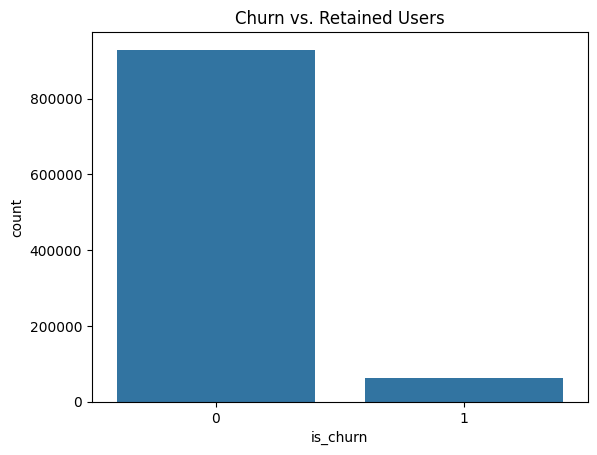

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

churn_counts = df['is_churn'].value_counts(normalize=True)
print(churn_counts)

sns.countplot(data=df, x='is_churn')
plt.title("Churn vs. Retained Users")
plt.show()

Confirms imbalance → important later for modeling

### Engagement Patterns

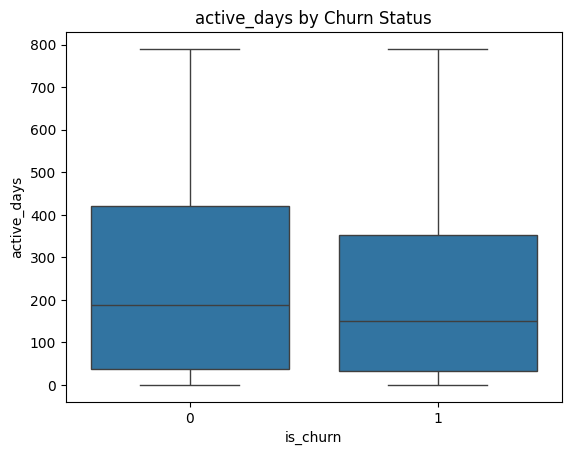

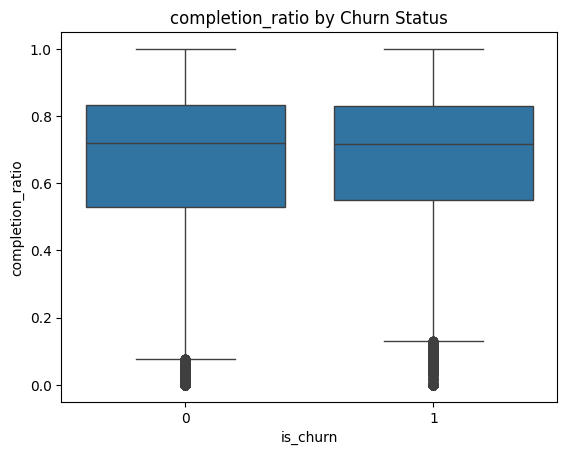

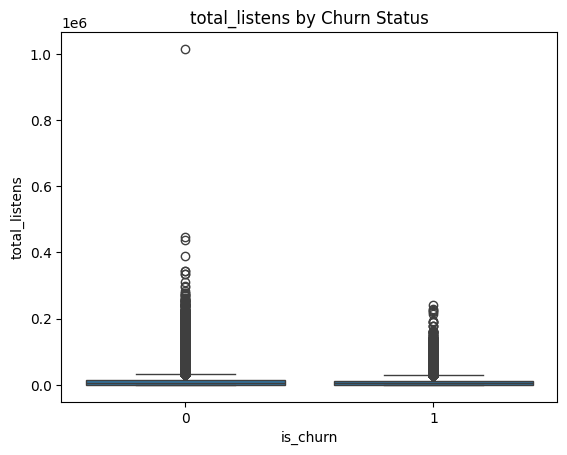

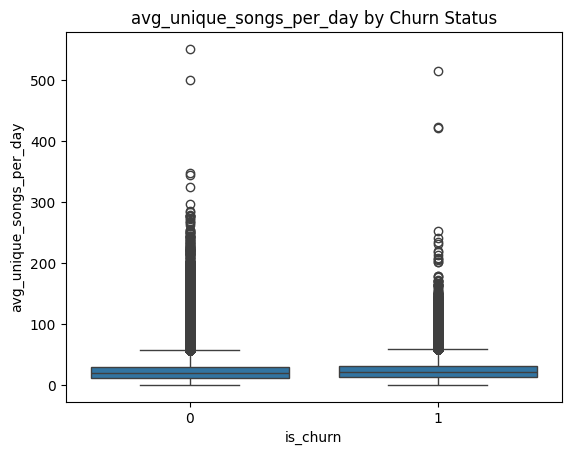

In [ ]:
engagement_vars = ['active_days', 'completion_ratio', 'total_listens', 'avg_unique_songs_per_day']

for col in engagement_vars:
    sns.boxplot(data=df, x='is_churn', y=col)
    plt.title(f"{col} by Churn Status")
    plt.show()

### Demographics & Registration

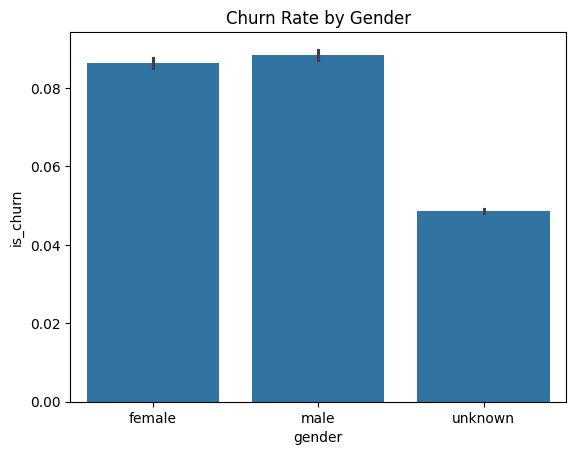

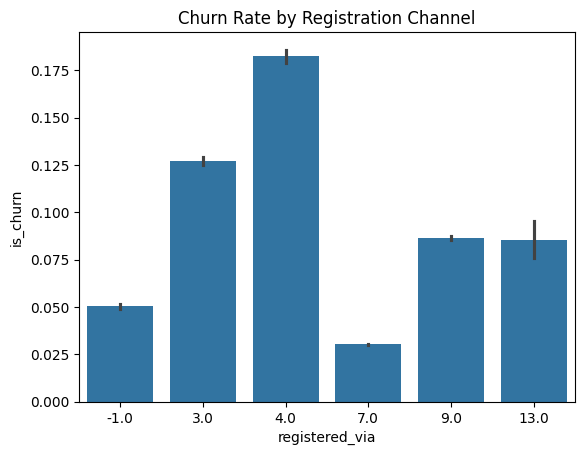

In [ ]:
sns.barplot(data=df, x='gender', y='is_churn')
plt.title("Churn Rate by Gender")
plt.show()

sns.barplot(data=df, x='registered_via', y='is_churn')
plt.title("Churn Rate by Registration Channel")
plt.show()

### Correlation Heatmap (Numeric Features)

In [ ]:
# Explicitly drop pseudo-numeric categorical columns
drop_cats = ["city", "registered_via", "reg_year", "reg_month"]  # if treating as categories
num_df = df.drop(columns=drop_cats, errors="ignore").select_dtypes(include=["number"])

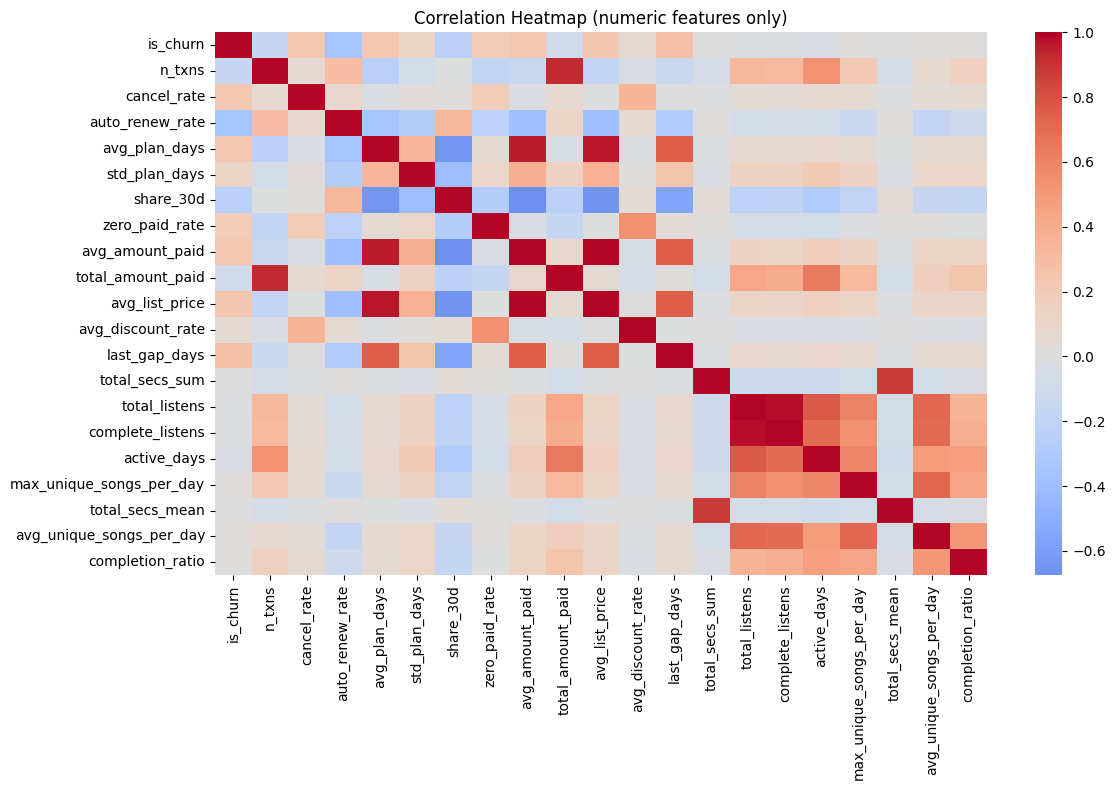

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(num_df.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (numeric features only)")
plt.tight_layout()
plt.show()

#### Correlation Insights

- **Cancellation & auto-renew** are the strongest churn indicators (direct subscription intent).  
- **Engagement metrics** like `active_days`, `total_listens`, and `completion_ratio` are negatively correlated with churn — active users are less likely to churn.  
- **Payment behavior** (`zero_paid_rate`, `avg_discount_rate`) also matters — users on free/promotional plans show higher churn.  
- Several engagement features are **highly collinear** (e.g., `total_secs_sum`, `total_listens`, `active_days`), all capturing overall user activity.


In [ ]:
# Correlation of all numeric features with churn
corr_to_churn = (
    df.select_dtypes(include=["number"])
      .corr(numeric_only=True)["is_churn"]
      .drop("is_churn")
      .sort_values(ascending=False)
)

print(corr_to_churn)

# Top + bottom
print("\nTop correlations with churn:")
print(corr_to_churn.head(10))

print("\nNegative correlations with churn:")
print(corr_to_churn.tail(10))

last_gap_days               0.279536
avg_list_price              0.239258
avg_plan_days               0.233834
avg_amount_paid             0.233808
cancel_rate                 0.233016
zero_paid_rate              0.184312
std_plan_days               0.118288
avg_discount_rate           0.055626
city                        0.055590
avg_unique_songs_per_day    0.024325
reg_year                    0.020431
completion_ratio            0.012921
max_unique_songs_per_day    0.005984
total_secs_sum              0.001501
total_secs_mean            -0.000934
reg_month                  -0.007358
complete_listens           -0.018735
total_listens              -0.019206
registered_via             -0.027162
active_days                -0.035941
total_amount_paid          -0.090291
n_txns                     -0.164531
share_30d                  -0.234668
auto_renew_rate            -0.349667
Name: is_churn, dtype: float64

Top correlations with churn:
last_gap_days               0.279536
avg_list_price

#### Correlation with Churn (Numeric Features)

We checked feature–target correlations to see which signals are most associated with churn.  

**Top positive correlations (higher values → higher churn risk):**
- `last_gap_days` (+0.28): recent inactivity strongly linked to churn.  
- `avg_list_price` / `avg_amount_paid` (+0.23): higher-paying users show higher churn, possibly short-term promo/bulk plan effects.  
- `cancel_rate` (+0.23): cancellations clearly predict churn.  
- `zero_paid_rate` (+0.18): free/promo users are more likely to churn.  

**Top negative correlations (higher values → lower churn risk):**
- `auto_renew_rate` (–0.35): strongest protective factor.  
- `share_30d` (–0.23): standard 30-day plan users are less likely to churn.  
- `n_txns` (–0.16): more transactions = more loyalty.  
- `active_days` (–0.04): activity helps, but effect size is small.  

**Takeaway:**  
Churn in KKBox is driven more by **subscription & billing behavior** (auto-renew, cancellations, gaps) than by raw listening activity. No single feature dominates, so predictive modeling is required to combine weak signals.


/tmp/ipython-input-164961307.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette="coolwarm")


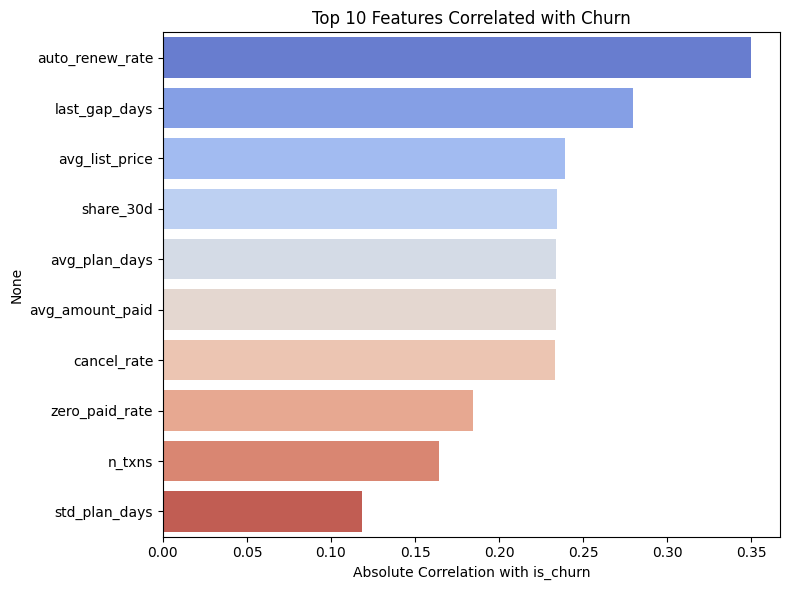

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

top_corr = corr_to_churn.abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette="coolwarm")
plt.title("Top 10 Features Correlated with Churn")
plt.xlabel("Absolute Correlation with is_churn")
plt.tight_layout()
plt.show()

### Churn by Subscription Behavior

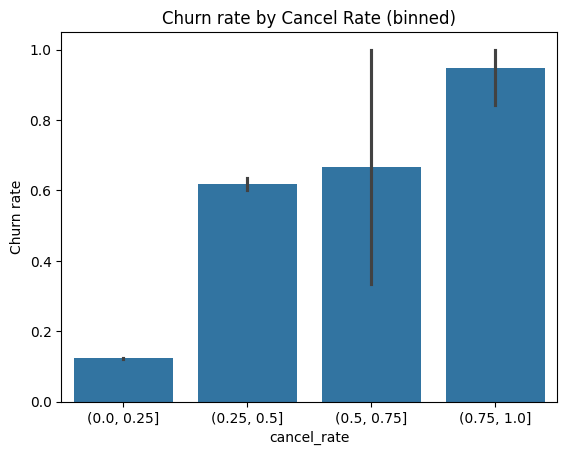

In [ ]:
sns.barplot(
    x=pd.cut(df["cancel_rate"], bins=[0,0.25,0.5,0.75,1]),
    y=df["is_churn"]
)
plt.title("Churn rate by Cancel Rate (binned)")
plt.ylabel("Churn rate")
plt.show()

### Churn by Plan Type

/tmp/ipython-input-2008663156.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plan_churn = df.groupby("plan_length_bucket")["is_churn"].mean()
/tmp/ipython-input-2008663156.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plan_churn.index, y=plan_churn.values, palette="Blues_r")


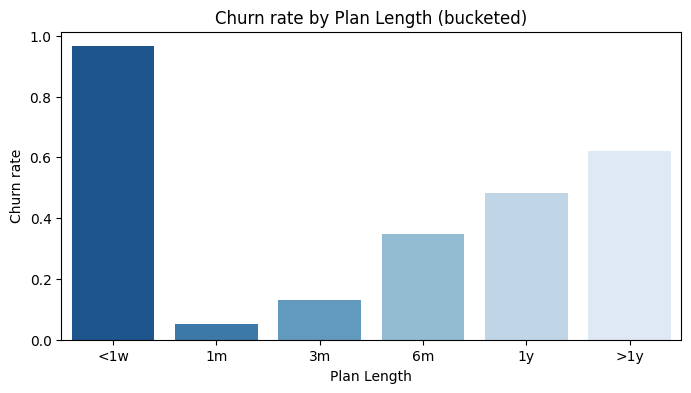

In [ ]:
# Bucket plan length into categories
bins = [0, 7, 30, 90, 180, 365, 1000]
labels = ["<1w", "1m", "3m", "6m", "1y", ">1y"]
df["plan_length_bucket"] = pd.cut(df["avg_plan_days"], bins=bins, labels=labels, include_lowest=True)

# Compute churn rate per bucket
plan_churn = df.groupby("plan_length_bucket")["is_churn"].mean()

# Plot
plt.figure(figsize=(8,4))
sns.barplot(x=plan_churn.index, y=plan_churn.values, palette="Blues_r")
plt.title("Churn rate by Plan Length (bucketed)")
plt.xlabel("Plan Length")
plt.ylabel("Churn rate")
plt.show()


### Engagement vs Churn

/tmp/ipython-input-3218215987.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_activity = df.groupby("active_days_bucket")["is_churn"].mean()


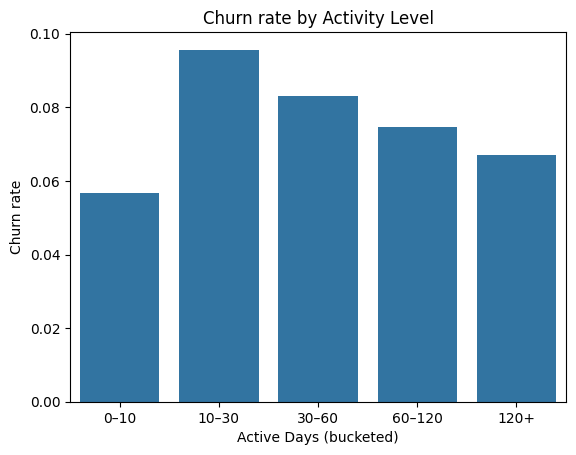

In [ ]:
# Bucket active_days
bins = [0, 10, 30, 60, 120, 365]
labels = ["0–10", "10–30", "30–60", "60–120", "120+"]
df["active_days_bucket"] = pd.cut(df["active_days"], bins=bins, labels=labels, include_lowest=True)

churn_by_activity = df.groupby("active_days_bucket")["is_churn"].mean()

sns.barplot(x=churn_by_activity.index, y=churn_by_activity.values)
plt.title("Churn rate by Activity Level")
plt.xlabel("Active Days (bucketed)")
plt.ylabel("Churn rate")
plt.show()

### Recent Gaps & Churn

/tmp/ipython-input-1667577458.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_gap = df.groupby("gap_bucket")["is_churn"].mean()
/tmp/ipython-input-1667577458.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_by_gap.index, y=churn_by_gap.values, palette="Blues_d")


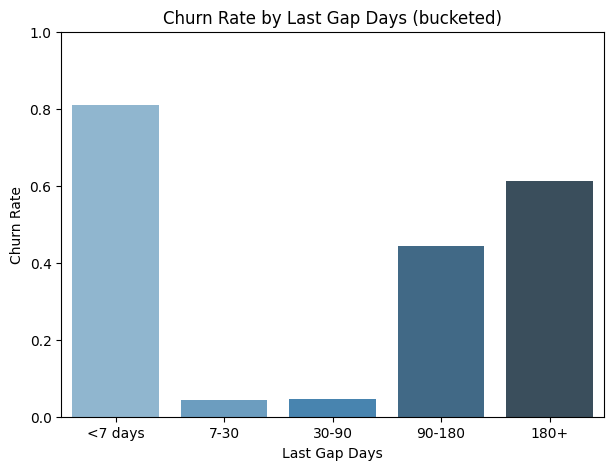

In [ ]:
# Bin last_gap_days into categories
bins = [0, 7, 30, 90, 180, 1000]
labels = ["<7 days", "7-30", "30-90", "90-180", "180+"]
df["gap_bucket"] = pd.cut(df["last_gap_days"], bins=bins, labels=labels, include_lowest=True)

# Compute churn rate by gap bucket
churn_by_gap = df.groupby("gap_bucket")["is_churn"].mean()

# Plot
plt.figure(figsize=(7,5))
sns.barplot(x=churn_by_gap.index, y=churn_by_gap.values, palette="Blues_d")
plt.title("Churn Rate by Last Gap Days (bucketed)")
plt.xlabel("Last Gap Days")
plt.ylabel("Churn Rate")
plt.ylim(0,1)
plt.show()

### Compare Survivors vs Churners

is_churn                   0           1
n_txns             16.347865   10.798853
avg_amount_paid   138.686228  268.938558
completion_ratio    0.622564    0.638004


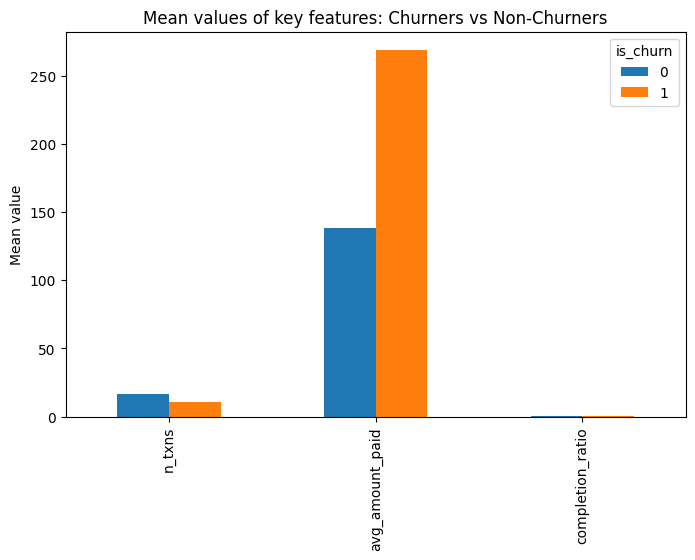

In [ ]:
summary = df.groupby("is_churn")[["n_txns", "avg_amount_paid", "completion_ratio"]].mean().T
print(summary)

summary.plot(kind="bar", figsize=(8,5))
plt.title("Mean values of key features: Churners vs Non-Churners")
plt.ylabel("Mean value")
plt.show()

#### 📊 Key Findings from EDA

- **Cancel rate** – The higher the cancel rate, the higher the chance of churn.  
  Users who frequently cancel renewals are at high risk.

- **Plan length** – Very short-term plans (<1 week) show the *highest churn*.  
  Medium-term plans (3–6 months, 1 year) have lower churn, but churn rises again for very long plans (>1 year), possibly due to promo-seekers or experimental users.

- **Engagement (active days)** – More activity generally means lower churn.  
  Interestingly, moderate activity (10–30 days) has slightly higher churn than heavy activity (60+ days), suggesting casual users are more likely to leave.

- **Last gap days** – Long gaps between sessions are a strong warning signal.  
  Users inactive for >90 days are much more likely to churn compared to recent users.

- **Churners vs. Non-Churners**:
  - **Churners**: fewer transactions, lower completion ratios, but surprisingly *higher average payment*.  
  - **Non-churners**: more consistent engagement and transactions, even if they spend less on average.  
    → **Loyalty seems to be driven more by steady usage than by one-time high spending.**

#### 🔑 Interpretation
These insights suggest that **churn is less about how much users pay and more about their engagement consistency**. To improve retention, product teams could:
- Encourage steady usage with **habit-forming nudges** (e.g., playlists, daily recommendations).  
- Offer **loyalty rewards for renewals** rather than short promos.  
- Target users with **long inactivity gaps** for re-engagement campaigns before churn solidifies.  

In the next notebook (03_churn_prediction_modeling.ipynb), we’ll try to predict churn effectively through modeling.